<a href="https://colab.research.google.com/github/Corry-Grodek/DataScience/blob/main/CorrGrodU8proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pymc-bart
import pymc_bart as pmb

In [2]:
import numpy as np
import arviz as az
import matplotlib.pyplot as plt
import pandas as pd
import pymc as pm
import pymc_bart as pmb
import seaborn as sns
from sklearn import tree

# Robots!

For this project I wanted to look at something timely and relavent to me. I chose to look at the First Robotics Competition scoring data as our team just qualified for worlds! This data was collected on Statbotics, a community project that tracks data for FRC robotics. In this years competition there are multiple ways to score points, and I want to see which way to score points best predicts a teams win rate.

In [3]:
#import data from statbotics, saved in my github
robo = pd.read_csv('https://raw.githubusercontent.com/Corry-Grodek/DataScience/refs/heads/main/2025_insightsTEXAS.csv')

#multiply winrate by 100 so it is easier to work with
robo.insert(robo.shape[1], "winP", robo['winrate']*100)
robo

,num,team,epa_rank,total_epa,norm_epa,unitless_epa,auto_epa,teleop_epa,endgame_epa,rp_1_epa,rp_2_epa,rp_3_epa,next_event_key,next_event_name,next_event_week,record,winrate,winP
0,118,Robonauts,4,108.1,1963,2046,23.8,72.7,11.5,0.91,1.00,0.85,NaN,NaN,NaN,96-8-0,0.923,92.3
1,3005,RoboChargers,13,93.8,1870,1949,21.2,62.8,9.8,0.74,0.61,0.65,2025cmptx,FIRST Championship,8.0,49-3-1,0.934,93.4
2,6800,Valor,20,90.9,1851,1929,21.8,56.3,12.8,0.60,0.63,0.63,NaN,NaN,NaN,47-6-0,0.887,88.7
3,6369,Mercenary Robotics,35,82.9,1800,1875,22.3,52.2,8.5,0.61,0.37,0.69,NaN,NaN,NaN,45-5-0,0.900,90.0
4,148,Robowranglers,123,70.4,1719,1790,12.4,50.3,7.7,0.66,0.46,0.59,2025cmptx,FIRST Championship,8.0,45-9-0,0.833,83.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182,6155,ElektraBots,3634,6.5,1355,1356,3.2,1.1,2.2,0.06,-0.16,0.06,NaN,NaN,NaN,9-15-2,0.385,38.5
183,5986,┌ Iron Fangs ┐,3648,5.9,1349,1352,2.7,1.3,1.8,-0.05,-0.16,0.03,NaN,NaN,NaN,12-11-2,0.520,52.0
184,3282,Dallas Robo Tigers,3654,5.3,1343,1348,2.1,1.4,1.8,-0.11,-0.06,0.08,NaN,NaN,NaN,4-8-0,0.333,33.3
185,9448,Wave Wranglers,3667,4.0,1330,1340,1.5,0.3,2.2,0.09,-0.16,0.12,NaN,NaN,NaN,2-26-0,0.071,7.1


(array([ 1.,  3., 14., 55., 51., 35., 13.,  8.,  2.,  5.]),
 array([ 7.1 , 15.73, 24.36, 32.99, 41.62, 50.25, 58.88, 67.51, 76.14,
        84.77, 93.4 ]),
 <BarContainer object of 10 artists>)

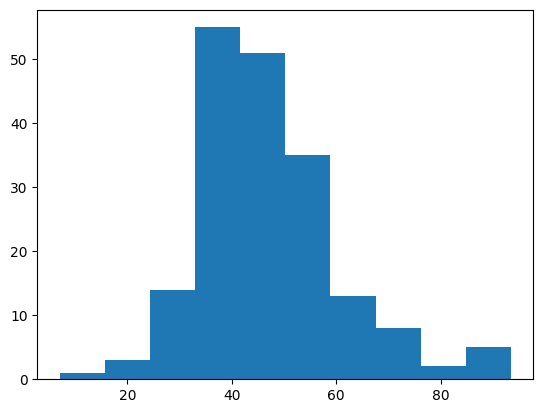

In [4]:
plt.hist(robo.winP)

In [5]:
#take the average of win rates
winavg = robo['winP'].mean()
winavg

46.7096256684492

This is a histogram of winrate percentage and the average win rate. It makes sense this will be close to 50%, for one team to win another has to lose. I think that the 4% difference is from ties.

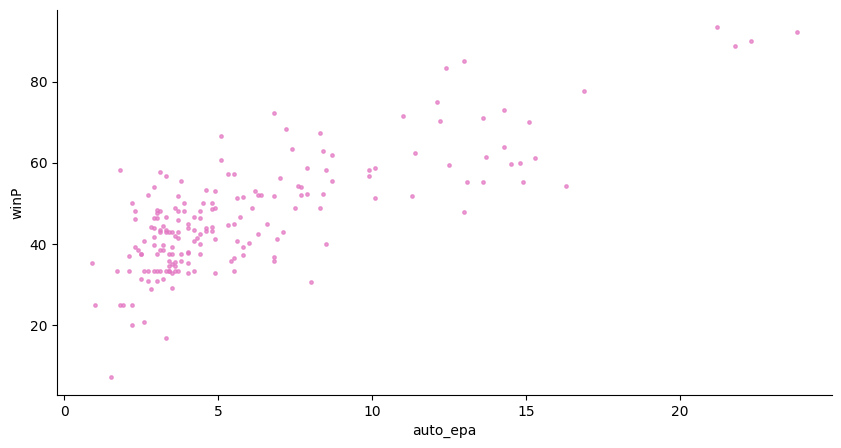

In [6]:
robo.plot(kind='scatter', x='auto_epa', y='winP', s=6, alpha=.7, c="C6", figsize=(10, 5), fontsize=10)
plt.gca().spines[['top', 'right',]].set_visible(False)

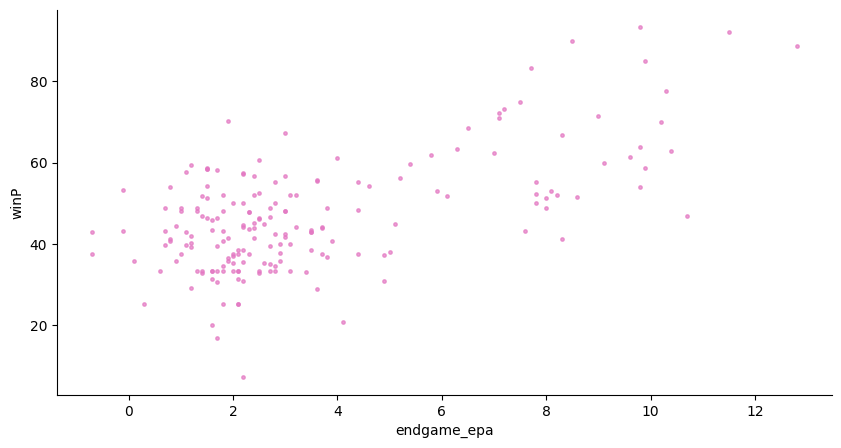

In [7]:
robo.plot(kind='scatter', x='endgame_epa', y='winP', s=6, alpha=.7, c="C6", figsize=(10, 5), fontsize=10)
plt.gca().spines[['top', 'right',]].set_visible(False)

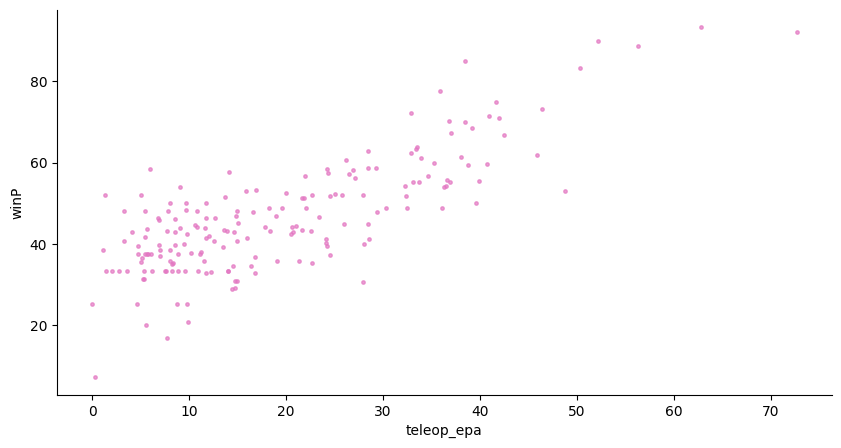

In [8]:
robo.plot(kind='scatter', x='teleop_epa', y='winP', s=6, alpha=.7, c="C6", figsize=(10, 5), fontsize=10)
plt.gca().spines[['top', 'right',]].set_visible(False)

These are scatter plots of winrate over the EPA of different scoring periods. EPA is the Expected Points Added, or how many points the team generally scores. All of these have a positive trend which makese sense, teams that score more will win more.

For my first model I want to try using just auto_epa. The Autonomous period is at the beggining of a match, so it would be cool if you could see a teams chance of winning from just the first part of a match.

In [9]:
X = robo["auto_epa"].to_numpy().reshape(-1, 1)
Y = robo["winP"].to_numpy()

with pm.Model() as model_robo:
    s = pm.HalfNormal('s',10)
    μ_ = pmb.BART("μ_", X, np.log(Y), m=46)
    μ = pm.Deterministic("μ",pm.math.exp(μ_))
    y = pm.Gamma("y", mu=μ, sigma=s,  observed=Y)
    idata_robo = pm.sample(compute_convergence_checks=False)


Output()

In [10]:
posterior_mean = idata_robo.posterior["μ"]

pm.sample_posterior_predictive(idata_robo,model_robo, extend_inferencedata=True)

μ_hdi = az.hdi(ary=idata_robo, group="posterior", var_names=["μ"], hdi_prob=0.74)

pps = az.extract( idata_robo, group="posterior_predictive", var_names=["y"] ).T

Output()

/usr/local/lib/python3.11/dist-packages/arviz/plots/hdiplot.py:166: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


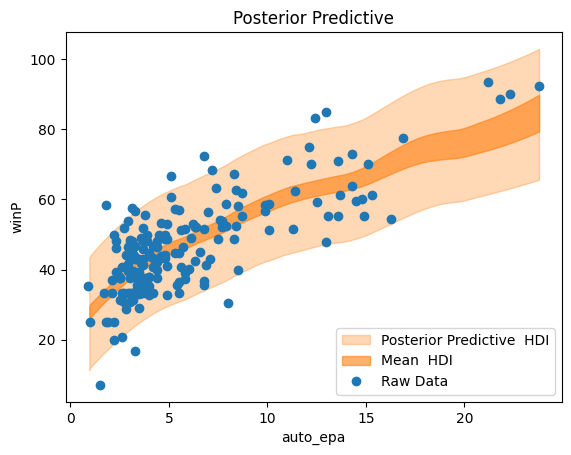

In [11]:
idx = np.argsort(X[:, 0])
fig, ax = plt.subplots()

az.plot_hdi(
    x=X[:, 0],
    y=pps,
    ax=ax,
    hdi_prob=0.93,
    fill_kwargs={"alpha": 0.3, "label": r"Posterior Predictive  HDI"},
)

az.plot_hdi(
    x=X[:, 0],
    y=posterior_mean,
    ax=ax,
    hdi_prob=0.74,
    fill_kwargs={"alpha": 0.6, "label": r"Mean  HDI"},
)
ax.plot(robo["auto_epa"], robo["winP"], "o", c="C0", label="Raw Data")
ax.legend(loc="lower right")
ax.set(
    title="Posterior Predictive",
    xlabel="auto_epa",
    ylabel="winP",
);

There is for sure a positive correlation, but for most of the Auto EPA's there is a lot of mix up and many teams are oustide of the HDI. This tells us teams with a very high auto EPA are likely to win more matches, but the low-mid range EPA's are kind of a toss up.

Now I wanted to try all three scoring periods and compare them.

In [12]:
clmn_list = ['num',
             'team',
             'epa_rank',
             'total_epa',
             'norm_epa',
             'unitless_epa',
             'auto_epa',
             'teleop_epa',
             'endgame_epa',
             'rp_1_epa',
             'rp_2_epa',
             'rp_3_epa',
             'next_event_key',
             'next_event_name',
             'next_event_week',
             'record',
             'winrate',
             'winP'
             ]
robo_stats =  robo.loc[:,clmn_list]

robo_nona = robo_stats

W = robo_nona[[
             'endgame_epa',
             'auto_epa',
             'teleop_epa'
             ]]

Y = robo["winP"].to_numpy()

In [13]:
with pm.Model() as model_robo2:
    s = pm.HalfNormal('s',20)
    μ_ = pmb.BART("μ_", W, np.log(Y), m=46)
    μ = pm.Deterministic("μ",pm.math.exp(μ_))
    y = pm.Gamma("y", mu=μ, sigma=s,  observed=Y)
    idata_robo2 = pm.sample(compute_convergence_checks=False)

pm.sample_posterior_predictive(idata_robo2,model_robo2, extend_inferencedata=True)

Output()

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

array([<Axes: xlabel='endgame_epa'>, <Axes: xlabel='auto_epa'>,
       <Axes: xlabel='teleop_epa'>], dtype=object)

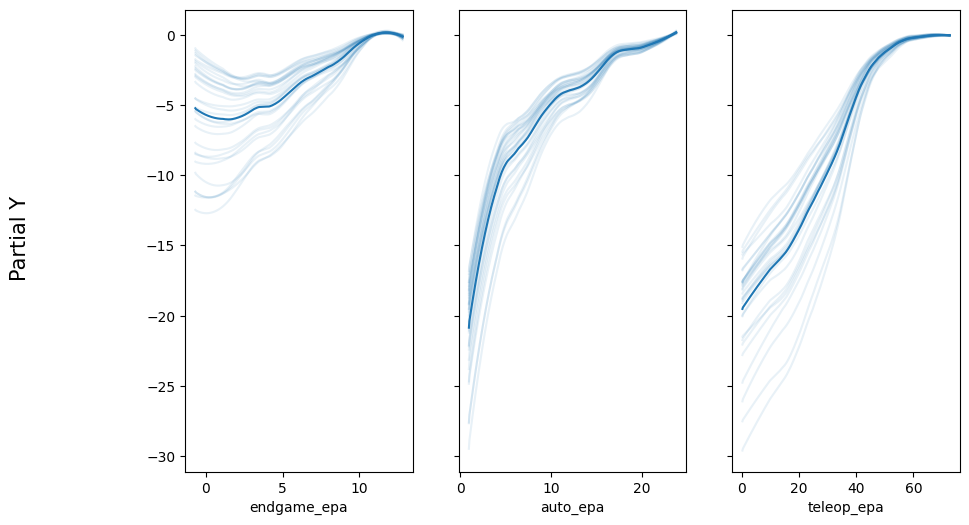

In [14]:
pmb.plot_ice( μ_, W, Y, grid=(1, 3), func=np.exp, figsize = (10,6))

The ICE plots suggest a similar thing as my first model, for all scoring periods the high EPA teams will have a high win rate, but the lower EPA teams are more competetive with eachother.

<Axes: ylabel='R²'>

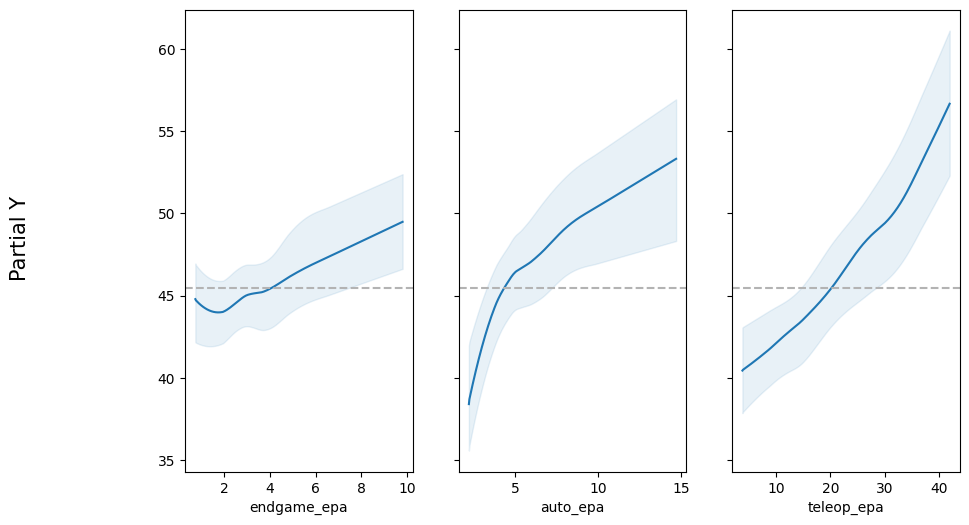

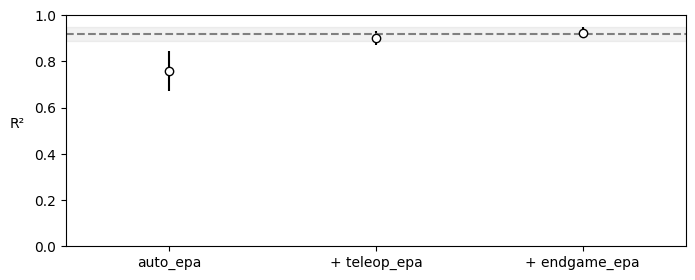

In [15]:
pmb.plot_pdp(μ_, W, Y, grid=(1, 3), func=np.exp, figsize = (10,6))
vi_robo2 = pmb.compute_variable_importance(idata_robo2, μ_, W)
pmb.plot_variable_importance(vi_robo2)

The PDP plots show that Teleop EPA has the most impact on winrate, but looking at the R^2 they are pretty close.

For my next model I tried all the relavent data I had. I included team number, as there was a chance older teams could perform better. The RP1, RP2, and RP3 are indiviudal ways to score points in a match.

In [16]:
T = robo_nona[[
             'endgame_epa',
             'auto_epa',
             'teleop_epa',
             'num',
             'epa_rank',
             'rp_1_epa',
             'rp_2_epa',
             'rp_3_epa',
             ]]


with pm.Model() as model_robo3:
    s = pm.HalfNormal('s',20)
    μ_ = pmb.BART("μ_", T, np.log(Y), m=46)
    μ = pm.Deterministic("μ",pm.math.exp(μ_))
    y = pm.Gamma("y", mu=μ, sigma=s,  observed=Y)
    idata_robo3 = pm.sample(compute_convergence_checks=False)

pm.sample_posterior_predictive(idata_robo3,model_robo3, extend_inferencedata=True)

Output()

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

/usr/local/lib/python3.11/dist-packages/pymc_bart/utils.py:516: UserWarning: The grid is smaller than the number of available variables to plot.
                Automatically adjusting the grid size.
  warnings.warn(


array([<Axes: xlabel='endgame_epa'>, <Axes: xlabel='auto_epa'>,
       <Axes: xlabel='teleop_epa'>, <Axes: xlabel='num'>,
       <Axes: xlabel='epa_rank'>, <Axes: xlabel='rp_1_epa'>,
       <Axes: xlabel='rp_2_epa'>, <Axes: xlabel='rp_3_epa'>], dtype=object)

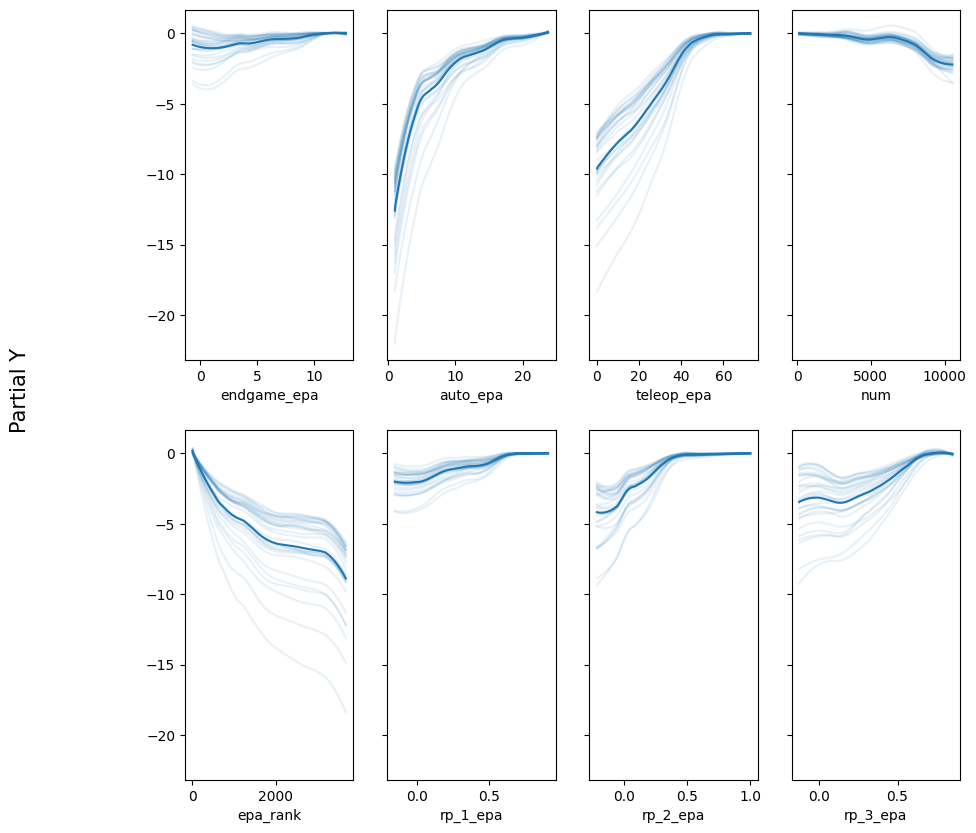

In [17]:
pmb.plot_ice( μ_, T, Y, grid=(1, 4), func=np.exp, figsize = (10,10))

<Axes: ylabel='R²'>

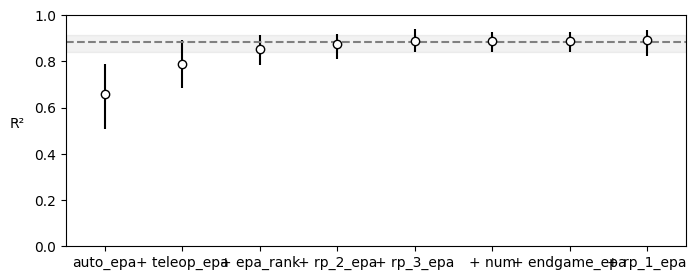

In [18]:
vi_robo3 = pmb.compute_variable_importance(idata_robo3, μ_, T)
pmb.plot_variable_importance(vi_robo3)

This is pretty much the same as the last model, Teleop EPA is the more important, with most of the other categories having minimal impact. Interestingly team number had the least impact, showing that a newer team has the same chance of winning as older teams.

As it turns out, there is no secret in finding a teams win rate. Teams that perform best during the teleoperated period are most likely to win matches. This makes sense, this is when the most points can be scored so if a team does not score as much in the other scoring periods this is where they can make it up. I think this shows that the FIRST Robotics staff has put a lot of effort into creating a game that is balanced and fair.